In [1]:
# !pip install kaggle
# !kaggle competitions download -c spaceship-titanic

import zipfile

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold

from lazypredict.Supervised import LazyClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(style='darkgrid')

import warnings
warnings.filterwarnings('ignore')

c:\Users\Yulun\anaconda3\envs\lazyp\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
with zipfile.ZipFile('spaceship-titanic.zip') as zipf:
    zipf.printdir()
    zipf.extractall(path='data/')

File Name                                             Modified             Size
sample_submission.csv                          2022-02-11 14:02:48        59902
test.csv                                       2022-02-11 14:02:48       372487
train.csv                                      2022-02-11 14:02:48       805421


In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

print(df_train.shape, df_test.shape)

(8693, 14) (4277, 13)


# EDA

In [4]:
# check for duplicates
print(df_train.duplicated().sum(), df_test.duplicated().sum())

0 0


No duplicate spotted in the original dataset.

In [5]:
# take a peek at the training and test sets
pd.concat([df_train.head(5), df_test.head(5)])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.00,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning,NaN
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.00,False,0.00,9.00,0.00,2823.00,0.00,Lerome Peckers,NaN
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.00,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus,NaN
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.00,False,0.00,6652.00,0.00,181.00,585.00,Meratz Caltilter,NaN
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.00,False,10.00,0.00,635.00,0.00,0.00,Brence Harperez,NaN


---
`PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

`HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.

`CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

`Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

`Destination` - The planet the passenger will be debarking to.

`Age` - The age of the passenger.

`VIP` - Whether the passenger has paid for special VIP service during the voyage.

`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

`Name` - The first and last names of the passenger.

`Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

---

Features that can be extracted from the given data:
- group information -- `PassengerId`
- deck, num and side -- `Cabin`
- family -- `Name`

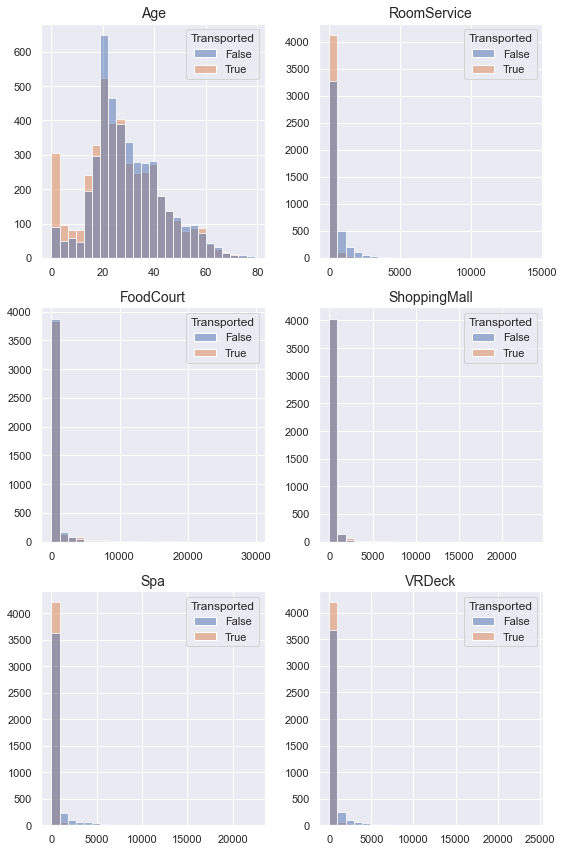

In [6]:
# columns of numerical features
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# visualise the relationship between the numerical features and the target
fig, axs = plt.subplots(3, 2, figsize=(8,12))

for i, col in enumerate(num_cols):
    ax = axs[i//2][i%2]
    sns.histplot(data=df_train, x=col, hue='Transported', bins=25, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(col, fontsize=14)

plt.tight_layout()
plt.show()

The distribution of the data for the five amenities were very similar. Most people do not purchase the amenities.

Maybe a feature representing total spend on all amenities or suggesting whether a person purchase at any amenity can be added.

In [7]:
# taking a closer look at the five amenities
df_train[num_cols[1:]].loc[(df_train[num_cols[1:]]==0).all(axis=1)]

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00
18,0.00,0.00,0.00,0.00,0.00
19,0.00,0.00,0.00,0.00,0.00
21,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...
8680,0.00,0.00,0.00,0.00,0.00
8681,0.00,0.00,0.00,0.00,0.00
8684,0.00,0.00,0.00,0.00,0.00
8685,0.00,0.00,0.00,0.00,0.00


Nearly half of the passengers did not purchase any of the amenity.

We can add a categorical feature representing whether a passenger spend money on any amenity.

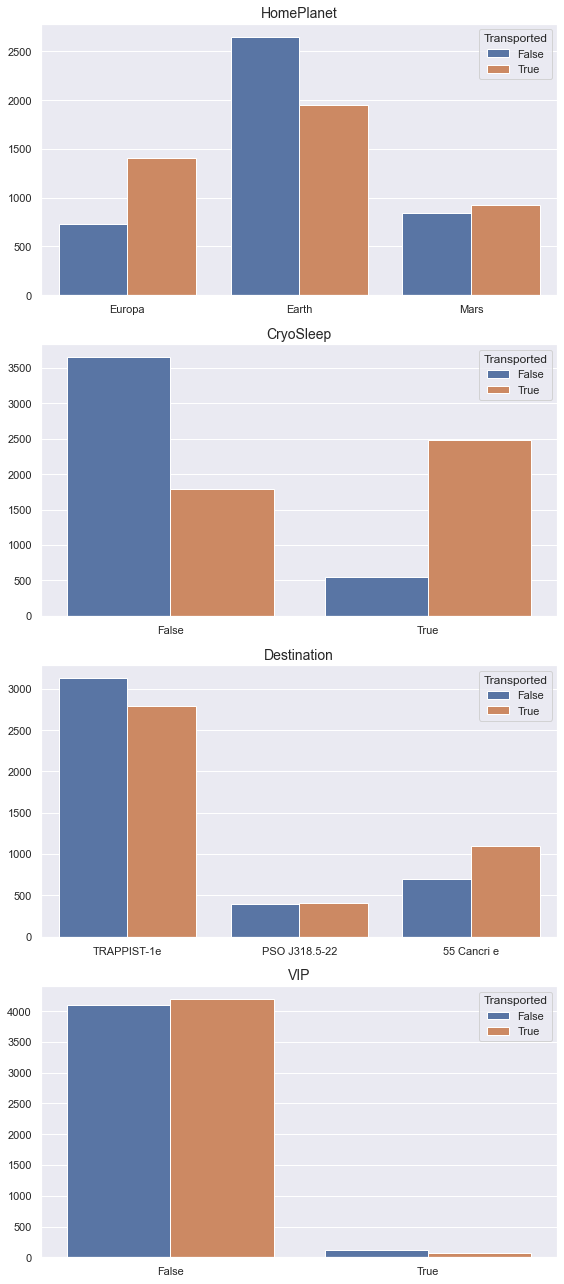

In [8]:
# columns of categorical features
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig, axs = plt.subplots(4, 1, figsize=(8,18))

for i, col in enumerate(cat_cols):
    ax = axs[i]
    sns.countplot(data=df_train, x=col, hue='Transported', ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(col, fontsize=14)

plt.tight_layout()
plt.show()

The `VIP` feature seems to have little relationship with the target, and most people are not VIPs.

Maybe removing it would be better.

In [9]:
# define a function to drop columns (making it easier for later stages)

def drop_col(cols):
    df_train.drop(cols, axis=1, inplace=True)
    df_test.drop(cols, axis=1, inplace=True)

In [10]:
# drop the VIP column
drop_col('VIP')

# and remove it from the cat_cols list
cat_cols.remove('VIP')

In [11]:
# explore the distribution of the target
df_train['Transported'].value_counts()/df_train.shape[0]

True    0.50
False   0.50
Name: Transported, dtype: float64

In [12]:
# inspect data types of all columns
df_train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Some columns have problematic data types. We need to take care of them later.

In [13]:
# missing values
print("Total number of missing value in the training set is", sum(df_train.isna().sum()))
print(df_train.isna().sum())

print("\nTotal number of missing value in the test set is", sum(df_test.isna().sum()))
print(df_test.isna().sum())

Total number of missing value in the training set is 2121
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Total number of missing value in the test set is 1024
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


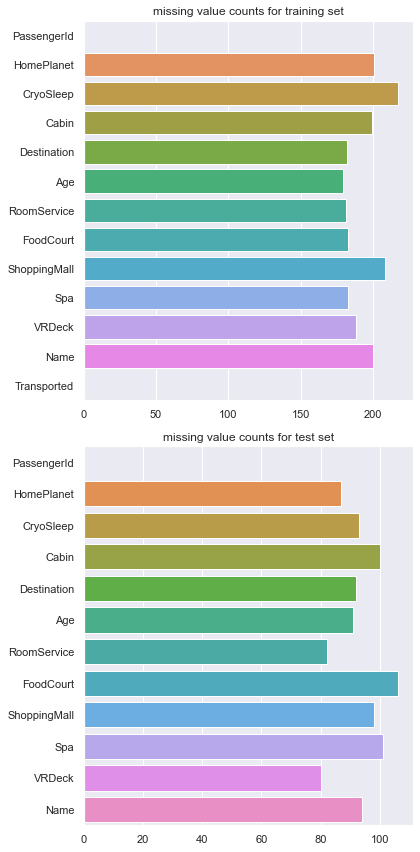

In [14]:
# visualise the count of missing value for each column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,12))

sns.barplot(x=df_train.isna().sum().values, y=df_train.columns, ax=ax1)
sns.barplot(x=df_test.isna().sum().values, y=df_test.columns, ax=ax2)

ax1.set_title('missing value counts for training set')
ax2.set_title('missing value counts for test set')

plt.tight_layout()
plt.show()

In [15]:
# number of rows with at least one missing value
na_train = df_train[df_train.isna().any(axis=1)].shape[0]
na_test = df_test[df_test.isna().any(axis=1)].shape[0]

print(f"There are {na_train} ({(na_train / df_train.shape[0] * 100):.2f}%) rows in the training set that have at least one missing value")
print(f"There are {na_test} ({(na_test / df_test.shape[0] * 100):.2f}%) rows in the test set that have at least one missing value")

There are 1922 (22.11%) rows in the training set that have at least one missing value
There are 925 (21.63%) rows in the test set that have at least one missing value


The missing data is quite spread out in all columns and rows.

We need to take care of them according to the data type of each feature. (We will do it later)

# Feature Engineering (creating new features based on existing ones)

### PassengerId

There is no missing value in the `PassengerId` column, so we can perform feature engineering without any preprocessing.

In [16]:
# extract group information from PassengerId

df_train['GroupId'] = df_train['PassengerId'].apply(lambda x: x[:4])
df_train['GroupNo'] = df_train['PassengerId'].apply(lambda x: x[5:])

df_test['GroupId'] = df_test['PassengerId'].apply(lambda x: x[:4])
df_test['GroupNo'] = df_test['PassengerId'].apply(lambda x: x[5:])

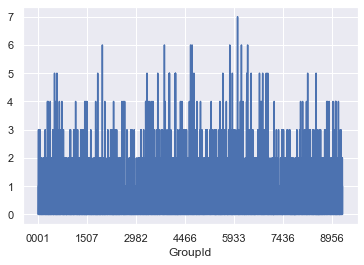

In [17]:
# number of transported passenger in each group
df_train.astype({'Transported': int}).groupby('GroupId').sum()['Transported'].plot()
plt.show()

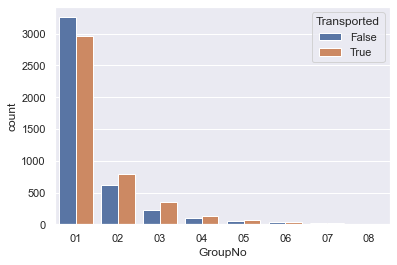

In [18]:
# for each group number
sns.countplot(data=df_train, x='GroupNo', hue='Transported')
plt.show()

The groupid feature can hardly be used for any model, because there are too many unique categories.

There is a way to compute it to make use of the group id information. We can know which group each passenger is in and we can also know how many passengers there are in each group. Hence we can create a new feature representing the size of the group a given passenger is in.

In [19]:
# generate a new dataframe containing sizes for all groups
groupsize = pd.concat([df_train['GroupId'], df_test['GroupId']]).value_counts()

# add a new column to represent group size
df_train['GroupSize'] = df_train['GroupId'].apply(lambda x: groupsize[x])
df_test['GroupSize'] = df_test['GroupId'].apply(lambda x: groupsize[x])

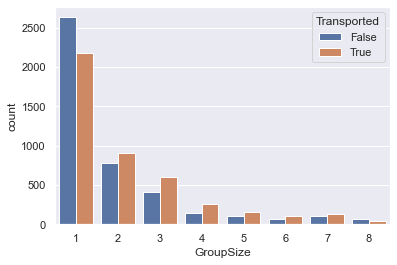

In [20]:
# visualise the distribution of group size data
sns.countplot(data=df_train, x='GroupSize', hue='Transported')
plt.show()

It seems that there are much more passengers in groups with size 1.

Hence we can create a binary categorical feature representing if a passenger is the only member in his/her group.

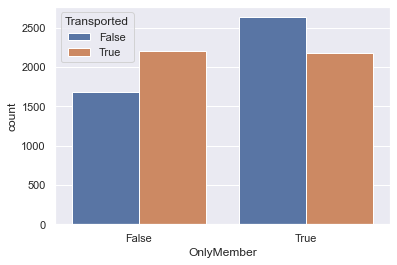

In [21]:
# add binary category for repersenting if a passenger is the only member in a group
df_train['OnlyMember'] = df_train['GroupSize'] == 1
df_test['OnlyMember'] = df_test['GroupSize'] == 1

# visualise its distribution
sns.countplot(data=df_train, x='OnlyMember', hue='Transported')
plt.show()

In [22]:
# discard unnecessary columns
drop_col(['PassengerId', 'GroupId'])

### Cabin

In [23]:
# temporarily fill the missing values for processing
df_train['Cabin'].fillna('#/#/#', inplace=True)
df_test['Cabin'].fillna('#/#/#', inplace=True)

# extract deck, num and side from Cabin
df_train['CabinDeck'] = df_train['Cabin'].apply(lambda x: x.split('/')[0])
df_train['CabinNum'] = df_train['Cabin'].apply(lambda x: x.split('/')[1])
df_train['CabinSide'] = df_train['Cabin'].apply(lambda x: x.split('/')[2])

df_test['CabinDeck'] = df_test['Cabin'].apply(lambda x: x.split('/')[0])
df_test['CabinNum'] = df_test['Cabin'].apply(lambda x: x.split('/')[1])
df_test['CabinSide'] = df_test['Cabin'].apply(lambda x: x.split('/')[2])

In [24]:
# retrieve the missing values
for col in ['CabinDeck', 'CabinNum', 'CabinSide']:
    df_train.loc[df_train[col] == '#', col] = np.nan
    df_test.loc[df_test[col] == '#', col] = np.nan

In [25]:
# check data types
df_train[['CabinDeck', 'CabinNum', 'CabinSide']].dtypes

CabinDeck    object
CabinNum     object
CabinSide    object
dtype: object

Cabin number data type is problematic.

In [26]:
# set correct data type (Num has to be float because np.nan cannot be convert to integer type)
# we will deal with the missing values later
df_train['CabinNum'] = df_train['CabinNum'].astype(float)
df_test['CabinNum'] = df_test['CabinNum'].astype(float)

In [27]:
# check unique values for each column
df_train[['CabinDeck', 'CabinNum', 'CabinSide']].nunique()

CabinDeck       8
CabinNum     1817
CabinSide       2
dtype: int64

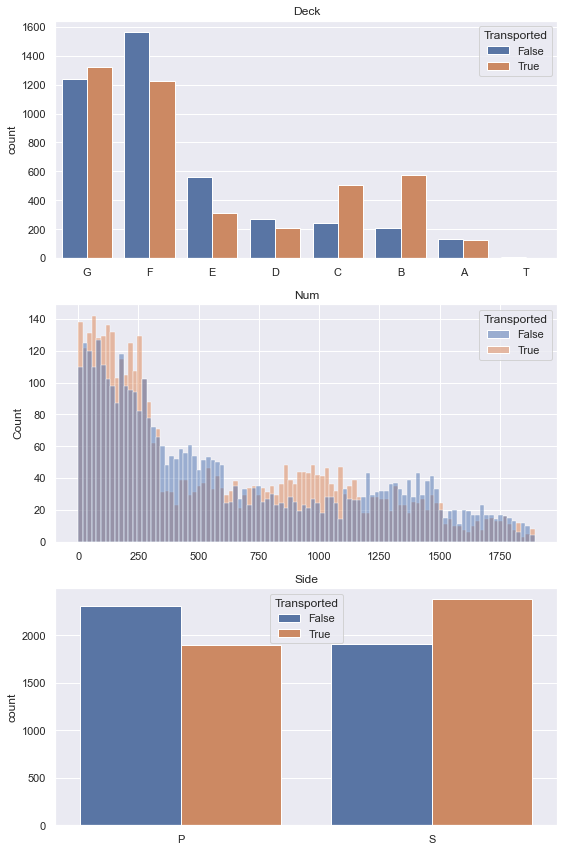

In [28]:
# visualise the distributions of cabin deck, cabin number and cabin side data
fig = plt.figure(figsize=(8,12))

plt.subplot(3,1,1)
sns.countplot(data=df_train, x='CabinDeck', hue='Transported', order=['G','F','E','D','C','B','A','T'])
plt.xlabel('')
plt.title('Deck')

plt.subplot(3,1,2)
sns.histplot(data=df_train, x='CabinNum', hue='Transported', bins=100)
plt.xlabel('')
plt.title('Num')

plt.subplot(3,1,3)
sns.countplot(data=df_train, x='CabinSide', hue='Transported')
plt.xlabel('')
plt.title('Side')

plt.tight_layout()
plt.show()

The cabin number shows some clear decrease in the counts of total passengers. 0~300 has the most passengers, 300~600 has significantly fewer passengers. 600~1500 has further lower number. And 1500 onward has the fewest passengers.

Hence we can probably use intervals with 300 (categorical data) rather than continuous data.

In [29]:
df_train['CabinNumInterval'] = pd.Series(str)
df_test['CabinNumInterval'] = pd.Series(str)

df_train.loc[df_train['CabinNum'] < 300, 'CabinNumInterval'] = '< 300'
df_test.loc[df_test['CabinNum'] < 300, 'CabinNumInterval'] = '< 300'

df_train.loc[(df_train['CabinNum'] >= 300) & (df_train['CabinNum'] < 600), 'CabinNumInterval'] = '300 ~ 600'
df_test.loc[(df_test['CabinNum'] >= 300) & (df_test['CabinNum'] < 600), 'CabinNumInterval'] = '300 ~ 600'

df_train.loc[(df_train['CabinNum'] >= 600) & (df_train['CabinNum'] < 900), 'CabinNumInterval'] = '600 ~ 900'
df_test.loc[(df_test['CabinNum'] >= 600) & (df_test['CabinNum'] < 900), 'CabinNumInterval'] = '600 ~ 900'

df_train.loc[(df_train['CabinNum'] >= 900) & (df_train['CabinNum'] < 1200), 'CabinNumInterval'] = '900 ~ 1200'
df_test.loc[(df_test['CabinNum'] >= 900) & (df_test['CabinNum'] < 1200), 'CabinNumInterval'] = '900 ~ 1200'

df_train.loc[(df_train['CabinNum'] >= 1200) & (df_train['CabinNum'] < 1500), 'CabinNumInterval'] = '1200 ~ 1500'
df_test.loc[(df_test['CabinNum'] >= 1200) & (df_test['CabinNum'] < 1500), 'CabinNumInterval'] = '1200 ~ 1500'

df_train.loc[df_train['CabinNum'] >= 1500, 'CabinNumInterval'] = '>= 1500'
df_test.loc[df_test['CabinNum'] >= 1500, 'CabinNumInterval'] = '>= 1500'

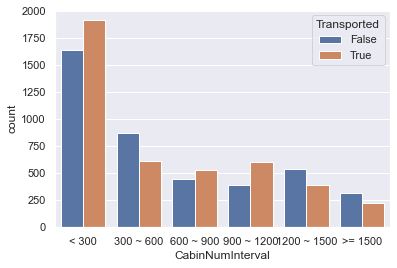

In [30]:
# check distribution
sns.countplot(data=df_train, x='CabinNumInterval', hue='Transported')
plt.show()

In [31]:
drop_col(['Cabin','CabinNum'])

### Name

In [32]:
# fill the missing values for processing
df_train['Name'].fillna('nan nan', inplace=True)
df_test['Name'].fillna('nan nan', inplace=True)

# extract family name information
df_train['FamilyName'] = df_train['Name'].apply(lambda x: x.split(' ')[1])
df_test['FamilyName'] = df_test['Name'].apply(lambda x: x.split(' ')[1])

In [33]:
# Number of unique values in FamilyName
df_train['FamilyName'].value_counts()

nan          200
Casonston     18
Oneiles       16
Domington     15
Litthews      15
            ... 
Secened        1
Foller         1
Unrespery      1
Diazarez       1
Tie            1
Name: FamilyName, Length: 2218, dtype: int64

Obviously this cannot be used as a feature for the model.

We can create another feature representing how many people in the same family are on the spaceship. (that's the size of the family for each passenger)

Maybe passengers with a larger family have higher probability to be transported.

In [34]:
# count number of people in each family
familysize = pd.concat([df_train, df_test])['FamilyName'].value_counts()

# create a new column containing sizes of family
df_train['FamilySize'] = df_train['FamilyName'].apply(lambda x: familysize[x])
df_test['FamilySize'] = df_test['FamilyName'].apply(lambda x: familysize[x])

In [35]:
# check unique family size values
df_train['FamilySize'].value_counts()

6      1009
5       979
7       974
4       805
9       763
8       753
3       616
10      583
11      441
2       425
12      344
14      208
294     200
13      165
1       133
15       98
16       94
18       43
17       38
19       22
Name: FamilySize, dtype: int64

In [36]:
df_train[df_train['FamilySize'] == 294].head()['FamilyName']

27     nan
58     nan
65     nan
77     nan
101    nan
Name: FamilyName, dtype: object

There is a size of 294 which is the place for 'nan' (missing value).

In [37]:
# retrieve the missing value
df_train.loc[df_train['FamilySize'] == 294, 'FamilySize'] = np.nan
df_test.loc[df_test['FamilyName'] == 'nan', 'FamilySize'] = np.nan

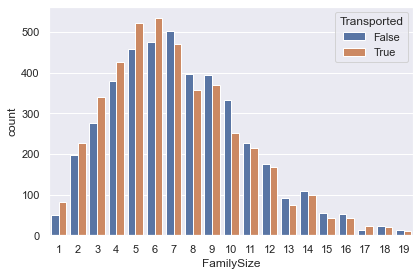

In [38]:
# visualise the distribution of family size
sns.countplot(data=df_train, x='FamilySize', hue='Transported')
plt.xticks(ticks=range(19), labels=range(1,20))
plt.tight_layout()
plt.show()

In [39]:
drop_col(['Name', 'FamilyName'])

For the five amenities, since there are missing values, we first need to clean the data (impute missing values).

# Data cleaning

In [40]:
# check data types
# do not need to bother for df_test because they are the same
print(df_train.dtypes)

HomePlanet           object
CryoSleep            object
Destination          object
Age                 float64
RoomService         float64
FoodCourt           float64
ShoppingMall        float64
Spa                 float64
VRDeck              float64
Transported            bool
GroupNo              object
GroupSize             int64
OnlyMember             bool
CabinDeck            object
CabinSide            object
CabinNumInterval     object
FamilySize          float64
dtype: object


The data type of `GroupNo` is problematic. It should be integer type instead of object.

Also the types for `Age` and `FamilySize` should both be integer instead of float. This is because there are missing values in these columns.

In [41]:
# convert the data type to integer
df_train['GroupNo'] = df_train['GroupNo'].astype(int)
df_test['GroupNo'] = df_test['GroupNo'].astype(int)

In [42]:
# check for missing values (because many new features have been added)
print("Total number of missing value in the training set is", sum(df_train.isna().sum()))
print(df_train.isna().sum())

print("\nTotal number of missing value in the test set is", sum(df_test.isna().sum()))
print(df_test.isna().sum())

Total number of missing value in the training set is 2519
HomePlanet          201
CryoSleep           217
Destination         182
Age                 179
RoomService         181
FoodCourt           183
ShoppingMall        208
Spa                 183
VRDeck              188
Transported           0
GroupNo               0
GroupSize             0
OnlyMember            0
CabinDeck           199
CabinSide           199
CabinNumInterval    199
FamilySize          200
dtype: int64

Total number of missing value in the test set is 1224
HomePlanet           87
CryoSleep            93
Destination          92
Age                  91
RoomService          82
FoodCourt           106
ShoppingMall         98
Spa                 101
VRDeck               80
GroupNo               0
GroupSize             0
OnlyMember            0
CabinDeck           100
CabinSide           100
CabinNumInterval    100
FamilySize           94
dtype: int64


The proposed approach is to use median of each column to impute missing values for numerical feature, and to use mode for categorical feature.

In [43]:
# use median to impute missing values for numerical data (can also use SimpleImputer in skilearn module)
na_num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'FamilySize']
for col in na_num_cols:
    print(f"All {col} in training set being set to {df_train[col].median()}")
    df_train[col].fillna(df_train[col].median(), inplace=True)
    
    print(f"All {col} in test set being set to {df_test[col].median()}")
    df_test[col].fillna(df_test[col].median(), inplace=True)

All Age in training set being set to 27.0
All Age in test set being set to 26.0
All RoomService in training set being set to 0.0
All RoomService in test set being set to 0.0
All FoodCourt in training set being set to 0.0
All FoodCourt in test set being set to 0.0
All ShoppingMall in training set being set to 0.0
All ShoppingMall in test set being set to 0.0
All Spa in training set being set to 0.0
All Spa in test set being set to 0.0
All VRDeck in training set being set to 0.0
All VRDeck in test set being set to 0.0
All FamilySize in training set being set to 7.0
All FamilySize in test set being set to 7.0


In [44]:
# use mode to impute missing values for categorical features
na_cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'CabinDeck', 'CabinSide', 'CabinNumInterval']
for col in na_cat_cols:
    print(f"All {col} in training set being set to {df_train[col].mode()[0]}")
    df_train[col].fillna(df_train[col].mode()[0], inplace=True)
    
    print(f"All {col} in test set being set to {df_test[col].mode()[0]}")
    df_test[col].fillna(df_test[col].mode()[0], inplace=True)

All HomePlanet in training set being set to Earth
All HomePlanet in test set being set to Earth
All CryoSleep in training set being set to False
All CryoSleep in test set being set to False
All Destination in training set being set to TRAPPIST-1e
All Destination in test set being set to TRAPPIST-1e
All CabinDeck in training set being set to F
All CabinDeck in test set being set to F
All CabinSide in training set being set to S
All CabinSide in test set being set to S
All CabinNumInterval in training set being set to < 300
All CabinNumInterval in test set being set to < 300


In [45]:
# check for missing values after the imputation
print("Total number of missing value in the training set is", sum(df_train.isna().sum()))
print(df_train.isna().sum())

print("\nTotal number of missing value in the test set is", sum(df_test.isna().sum()))
print(df_test.isna().sum())

Total number of missing value in the training set is 0
HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Transported         0
GroupNo             0
GroupSize           0
OnlyMember          0
CabinDeck           0
CabinSide           0
CabinNumInterval    0
FamilySize          0
dtype: int64

Total number of missing value in the test set is 0
HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
GroupNo             0
GroupSize           0
OnlyMember          0
CabinDeck           0
CabinSide           0
CabinNumInterval    0
FamilySize          0
dtype: int64


In [46]:
# check data types
df_train.dtypes

HomePlanet           object
CryoSleep              bool
Destination          object
Age                 float64
RoomService         float64
FoodCourt           float64
ShoppingMall        float64
Spa                 float64
VRDeck              float64
Transported            bool
GroupNo               int32
GroupSize             int64
OnlyMember             bool
CabinDeck            object
CabinSide            object
CabinNumInterval     object
FamilySize          float64
dtype: object

In [47]:
# convert data type to integer
df_train[['Age', 'FamilySize']] = df_train[['Age', 'FamilySize']].astype(int)
df_test[['Age', 'FamilySize']] = df_test[['Age', 'FamilySize']].astype(int)

# and recheck
df_train.dtypes

HomePlanet           object
CryoSleep              bool
Destination          object
Age                   int32
RoomService         float64
FoodCourt           float64
ShoppingMall        float64
Spa                 float64
VRDeck              float64
Transported            bool
GroupNo               int32
GroupSize             int64
OnlyMember             bool
CabinDeck            object
CabinSide            object
CabinNumInterval     object
FamilySize            int32
dtype: object

There is now no missing value and the data types are all correct.

# Feature engineering (Amenities)

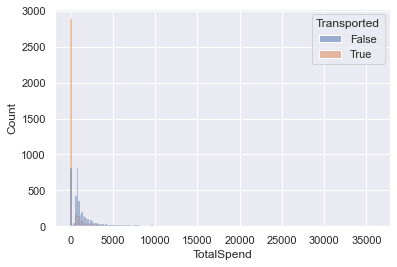

In [48]:
# create a total sepnd column
df_train['TotalSpend'] = df_train[num_cols[1:]].sum(axis=1)
df_test['TotalSpend'] = df_test[num_cols[1:]].sum(axis=1)

# inspect the distribution of it
sns.histplot(data=df_train, x='TotalSpend', hue='Transported', bins=200)
plt.show()

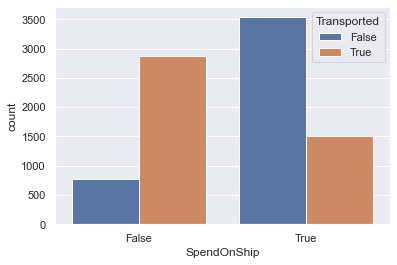

In [49]:
# create binary categorical data for pay/not pay for any amenity
df_train['SpendOnShip'] = df_train['TotalSpend'] > 0
df_test['SpendOnShip'] = df_test['TotalSpend'] > 0

# visualise the distribution
sns.countplot(data=df_train, x='SpendOnShip', hue='Transported')
plt.show()

In [50]:
drop_col('TotalSpend')

# Data pre-processing

In [51]:
num_cols, cat_cols = [], []
for col_name in df_test.columns:
    if df_train.dtypes[col_name] == int or df_train.dtypes[col_name] == float:
        num_cols.append(col_name)
    else:
        cat_cols.append(col_name)

print("Numerical features: ", num_cols)
print("Categorical features: ", cat_cols)

Numerical features:  ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupNo', 'FamilySize']
Categorical features:  ['HomePlanet', 'CryoSleep', 'Destination', 'GroupSize', 'OnlyMember', 'CabinDeck', 'CabinSide', 'CabinNumInterval', 'SpendOnShip']


Note that although the data type of group number `GroupNo` is integer, it should actually be treated as a categorical data because the number itself doesn't have numerical meanings but rather act as a label.

In [52]:
# GroupNo should be categorical feature
num_cols.remove('GroupNo')
cat_cols.append('GroupNo')

The numerical features need to be scaled and the categorical features need to be encoded.

But before that, we need to check the distribution of the numerical data to ensure a normal-like structure.

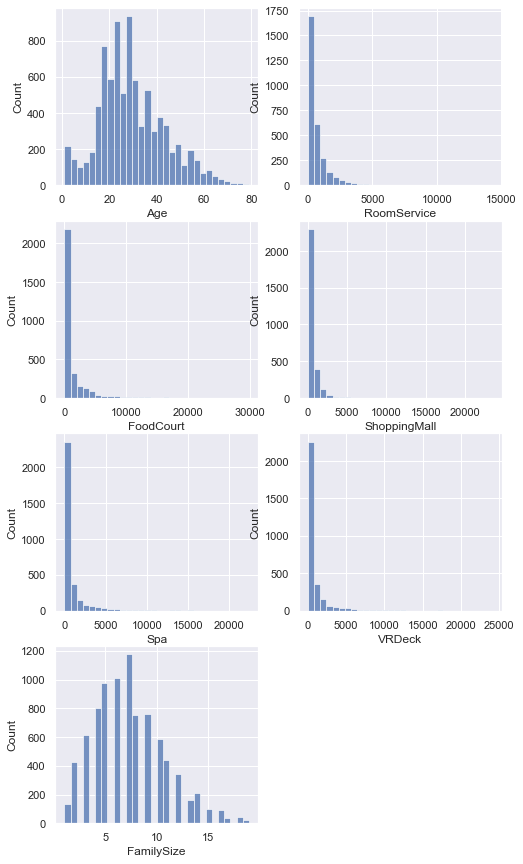

In [53]:
# check distributions of the numerical data (only check values greater than 0)
plt.figure(figsize=(8, 15))

for i, col in enumerate(num_cols):
    plt.subplot(4, 2, i+1)
    sns.histplot(data=df_train[df_train[col]>0], x=col, bins=30)

plt.show()

The distributions of the five amenities seem unnormal. We need to log-transform them.

In [54]:
# log transformation
for col in num_cols[1:6]:
    df_train[col] = np.log(df_train[col] + 1)
    df_test[col] = np.log(df_test[col] + 1)

In [55]:
# use LabelEncoder to encode categorical values
le = LabelEncoder()

# create a dictionary to memorise the pairs of all the categories with the corresponding labels (for looking up the meaning of the label)
label_memo = {}

for col in cat_cols:
    uniq_cat = np.union1d(df_train[col].unique(), df_test[col].unique())
    le.fit(uniq_cat)
    
    # add memo
    memo = {}
    for i, cat in enumerate(uniq_cat):
        memo[le.transform(uniq_cat)[i]] = cat
    label_memo[col] = memo
    
    # encode the column
    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

In [56]:
# also encode the target variable
le.fit([True, False])
temp_memo = {}

for i, cat in enumerate([True, False]):
    temp_memo[le.transform([True, False])[i]] = cat
label_memo['Transported'] = temp_memo

# encode the column
df_train['Transported'] = le.transform(df_train['Transported'])

In [57]:
# an example of looking up a label
# say I want to know what it means for a 1 for the CabinNumInterval feature
label_memo['CabinNumInterval'][1]

'300 ~ 600'

In [58]:
df_train.dtypes

HomePlanet            int32
CryoSleep             int64
Destination           int32
Age                   int32
RoomService         float64
FoodCourt           float64
ShoppingMall        float64
Spa                 float64
VRDeck              float64
Transported           int64
GroupNo               int64
GroupSize             int64
OnlyMember            int64
CabinDeck             int32
CabinSide             int32
CabinNumInterval      int32
FamilySize            int32
SpendOnShip           int64
dtype: object

In [59]:
label_memo

{'HomePlanet': {0: 'Earth', 1: 'Europa', 2: 'Mars'},
 'CryoSleep': {0: False, 1: True},
 'Destination': {0: '55 Cancri e', 1: 'PSO J318.5-22', 2: 'TRAPPIST-1e'},
 'GroupSize': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8},
 'OnlyMember': {0: False, 1: True},
 'CabinDeck': {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'T'},
 'CabinSide': {0: 'P', 1: 'S'},
 'CabinNumInterval': {0: '1200 ~ 1500',
  1: '300 ~ 600',
  2: '600 ~ 900',
  3: '900 ~ 1200',
  4: '< 300',
  5: '>= 1500'},
 'SpendOnShip': {0: False, 1: True},
 'GroupNo': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8},
 'Transported': {1: True, 0: False}}

Next we need to scale the numeriacl features.

In [60]:
scaler = StandardScaler()
for col in num_cols:
    df_train[col] = scaler.fit_transform(df_train[col].values.reshape(-1,1))
    df_test[col] = scaler.fit_transform(df_test[col].values.reshape(-1,1))

# Model

First we need to prepare the data that we are going to use to fit the model.

In [61]:
# feature names
features = df_test.columns.tolist()
features

['HomePlanet',
 'CryoSleep',
 'Destination',
 'Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'GroupNo',
 'GroupSize',
 'OnlyMember',
 'CabinDeck',
 'CabinSide',
 'CabinNumInterval',
 'FamilySize',
 'SpendOnShip']

In [62]:
# prepare data
X = df_train[features].values
y = df_train['Transported'].values

# split train data and test data for the model selection
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2022, test_size=0.25)

Use `lazypredict.Supervised.LazyClassifier` to lazily explore the performance of different models.

In [63]:
lazy_clf = LazyClassifier(random_state=2022, ignore_warnings=True, verbose=0)

lazy_model, lazy_prd = lazy_clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:11<00:00,  2.53it/s]


In [64]:
lazy_model[:10]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.80,0.80,0.80,0.80,0.15
XGBClassifier,0.80,0.80,0.80,0.80,0.21
RandomForestClassifier,0.80,0.80,0.80,0.80,0.71
ExtraTreesClassifier,0.79,0.79,0.79,0.79,0.64
LinearSVC,0.78,0.78,0.78,0.78,0.30
LogisticRegression,0.78,0.78,0.78,0.78,0.03
SVC,0.78,0.78,0.78,0.78,1.02
AdaBoostClassifier,0.78,0.78,0.78,0.78,0.30
CalibratedClassifierCV,0.78,0.78,0.78,0.78,1.33


The model with the best performance is LGBMClassifier, which stands for Light Gradient Boosting Model.

# LGBM with Grid Search

In [65]:
# initialise LGBM classifier
lgbm = LGBMClassifier(random_state=2022)

# grid search parameters
params = {'boosting_type': ['gbdt', 'dart', 'goss'],
          'max_depth': [15, 20, 25],
          'learning_rate': [0.02, 0.06, 0.1],
          'n_estimators': [100, 150, 200, 250]}

In [66]:
clf = GridSearchCV(lgbm, params, cv=None, n_jobs=-1)

clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

best_params = clf.best_params_
print(best_params)

0.796688132474701
{'boosting_type': 'gbdt', 'learning_rate': 0.06, 'max_depth': 25, 'n_estimators': 100}


In [67]:
# use the best parameters
lgbm = LGBMClassifier(**best_params, random_state=2022)

# cv score
cv_score = cross_val_score(lgbm, X, y, cv=9, scoring='accuracy')
print(f"The average cv score is {cv_score.mean():.4f} with a standard deviation of {cv_score.std():.4f}")

The average cv score is 0.8029 with a standard deviation of 0.0184


# Make predictions (9 folds)

In [68]:
# prepare feature data for the target
feature_target = df_test[features].values

# initialise an array for comtaining the predictions
target = np.zeros(df_test.shape[0])

In [69]:
# 9 folds
skf = StratifiedKFold(n_splits=9, shuffle=True, random_state=2022)

for index_train, _ in skf.split(X, y):
    X_train, y_train = X[index_train], y[index_train]
    
    # fit model
    lgbm.fit(X_train, y_train)
    
    # make predictions
    predictions = lgbm.predict(feature_target)
    
    # add predictions to the final target

    target += predictions

In [70]:
# add the result to the dataframe
df_test['Transported'] = target >= 5
df_test.head()

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupNo,GroupSize,OnlyMember,CabinDeck,CabinSide,CabinNumInterval,FamilySize,SpendOnShip,Transported
0,0,1,2,-0.11,-0.64,-0.65,-0.63,-0.66,-0.62,0,0,1,6,1,4,0.23,0,True
1,0,0,2,-0.68,-0.64,0.14,-0.63,2.23,-0.62,0,0,1,5,1,4,-0.93,1,False
2,1,1,0,0.17,-0.64,-0.65,-0.63,-0.66,-0.62,0,0,1,2,1,4,-0.35,0,True
3,1,0,2,0.67,-0.64,2.36,-0.63,1.23,1.72,0,0,1,2,1,4,-1.52,1,True
4,0,0,2,-0.61,0.23,-0.65,1.87,-0.66,-0.62,0,0,1,5,1,4,-0.64,1,False
